In [19]:
import numpy as np
import pandas as pd
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.lines as mlines
import matplotlib.ticker as mtick
import matplotlib as mpl
import lookup_us_state_abbrev as lusa #Local package

# Graphic params
%matplotlib inline
style.use('fivethirtyeight')
matplotlib.rcParams['figure.dpi'] = 250
matplotlib.rcParams['font.sans-serif'] = ['Arial']

"""

Read data files
[add additional documentation on data sources here]

"""
df_votes = pd.read_csv('data/1976-2020-president.csv')
df_electoral_votes = pd.read_csv('data/electoral_vote_data.csv')


def clean_datasets(df_votes=df_votes,df_electoral_votes=df_electoral_votes):
    """
    For DataFrames in data import, returns a clean DataFrame for knapsack calculations,
    """

    # Strip asterisks and convert state names to upper
    df_electoral_votes['state'] = df_electoral_votes['state'].str.replace('*','')
    df_electoral_votes['state'] = df_electoral_votes['state'].str.upper()

    # Join data
    df = pd.merge(df_votes, df_electoral_votes, on=['state', 'year'], how='left', validate='many_to_one')

    # Calculate electoral votes earned by each candidate in each state in each year
    df['candidatevotes_max'] = df['candidatevotes'].groupby([df['year'],df['state']]).transform('max')
    df['electoral_votes_candidate'] = np.where(df['candidatevotes'] == df['candidatevotes_max'], df['electoral_votes'],0)
    
    # Fix data error in 2004
    df.loc[df['candidate'] == 'MITT, ROMNEY','candidate'] = 'ROMNEY, MITT'
    
    return df


def calculate_state_margins(year,df):
    """
    
    Prepares inputs for the knapsack solver.
    
    Parameters:
    ------------
    year: int, year to run the solver on
    df: DataFrame, clean DataFrame containing candidate-state-year level election results produced by the function clean_datasets()
    
    Returns:
    ------------
    margins: Nested tuple containing (1): the EV differential that the loser needs to make up
                                     (2): nested list containing the state, flip margin, and electoral votes associated with each state
    """
    df_year = copy.deepcopy(df.loc[df['year'] == year])

    # Find electoral votes by candidate and second place candidate
    electoral_votes_by_candidate = df_year['electoral_votes_candidate'].groupby([df_year['candidate']]).sum().sort_values(ascending=False)
    winning_candidate, candidate = electoral_votes_by_candidate.index[0], electoral_votes_by_candidate.index[1]

    # Electoral votes for given candidate, and differential needed to make up
    # Note: assumes third party candidate does not win state
    ev_candidate = electoral_votes_by_candidate[electoral_votes_by_candidate.index == candidate][0]
    ev_differential = electoral_votes_by_candidate.max() - ev_candidate

    # Winner for each state
    df_year['state_winner'] = np.where(df_year['candidatevotes'].eq(df_year.groupby('state')['candidatevotes'].transform(max)), df_year.candidate, np.nan)
    df_year['state_winner'] = df_year.groupby('state')['state_winner'].transform('first')

    # We only want to consider a loser's lost states
    lost_states = set(df_year['state'].loc[candidate != df_year['state_winner']])

    # Compute flip margins for each state
    raw_margins = []
    for state in lost_states:
        df_state = df_year.loc[df_year['state'] == state]
        df_margin = df_state.loc[(df_state['candidate'] == df_state['state_winner']) | (df_state['candidate'] == candidate)].sort_values(by='candidatevotes', ascending=False)
        margin = df_margin.iloc[0]['candidatevotes'] - df_margin.iloc[1]['candidatevotes']
        flip_margin = margin//2 + 1

        evs = int(df_electoral_votes.loc[(df_electoral_votes['state'] == state) & (df_electoral_votes['year'] == year),'electoral_votes'].values)
        raw_margins.append([state,flip_margin,evs])
    
    # First arg is ev differential
    return (ev_differential,raw_margins)
    
def solve_knapsack(margins):
    """
    
    This function finds, for a given election (year), the collection of states required to be flipped for the loser to win the election, minimizing the total number of votes that need to be flipped.
    
    Parameters:
    ------------
    margins: tuple, nested tuple containing (1): the EV differential that the loser needs to make up
                                      (2): nested list containing the state, flip margin, and electoral votes associated with each state
                            (produced by calculate_state_margins() function, runs for a given year)
    
    Returns:
    ------------
    flip_states: list, the collection of states
    """

    ev_differential = margins[0]
    states, votes, evs = list(zip(*margins[1]))

    item_weights = evs
    item_values = votes

    n = len(item_weights)
    W = sum(evs) - int(ev_differential//2 + 1)

    M = np.zeros(shape=(n,W+1))
    used_items = {}

    # Create matrix of items and weights, save "improvements" over subproblems for larger problems
    for row in range(n):
        for col in range(W+1):
            used_items[(-1, col)] = []
            
            # Iterate through items
            item_weight = item_weights[row]
            item_value = item_values[row]
            max_weight = col
            
            if item_weight < max_weight:

                    # If new state is added (can improve solution)
                    if item_value + M[row-1][col-item_weight] > M[row-1][col]:
                        M[row][col] = item_value + M[row-1][col-item_weight]

                        used_items[(row,col)] = copy.deepcopy(used_items[(row-1,col-item_weight)])                     
                        used_items[(row,col)].extend([states[row]])

                    # If no change
                    else:
                        M[row][col] = M[row-1][col]
                        used_items[(row,col)] = copy.deepcopy(used_items[(row-1,col)])
                        
            # No change (cannot improve solution)
            else:
                M[row][col] = M[row-1][col]

                used_items[(row,col)] = copy.deepcopy(used_items[(row-1,col)])

    flip_states = list(state for state in states if state not in used_items[max(used_items)])
    return flip_states

def calculate_used_flip_margins(flip_states,margins):
    """
    Returns the number of votes needed to flip the result in each state that is part of the knapsack result
    
    Parameters:
    ------------
    flip_states, list: list of states returned by the knapsack solver that the loser needs to flip
    margins: tuple, nested tuple containing (1): the EV differential that the loser needs to make up
                                      (2): nested list containing the state, flip margin, and electoral votes associated with each state
                            (produced by calculate_state_margins() function, runs for a given year)
    
    Returns:
    ------------
    yearly_results: list, collection of states needed to flip result and within-state flip margins    
    """
    state_level = [m for m in margins[1] if m[0] in flip_states]
    return state_level

def clean_candidate_name(name):
    """
    Clean a candidate name for display (proper case and moves last name after comma)
    """
    new_name = str.title(name)
    x = new_name.split(',')
    new_name = x[1] + ' ' + x[0]
    return str.strip(new_name)
    
    
"""
Run functions above, produce clean results, and prepare datasets for graphics.
Graphics are run and exported from individual cells below.

"""

# Run functions to create clean dataset, run knapsack calculation, and get results
df = clean_datasets()

yearly_results = dict()
for year in range(1976,2024,4):
    margins = calculate_state_margins(year=year,df=df)
    flip_states = solve_knapsack(margins)
    yearly_results[year] = calculate_used_flip_margins(flip_states,margins)

# Get total flip margin
total = {year: sum(i[1] for i in yearly_results[year]) for year in yearly_results}
df_total = pd.DataFrame.from_dict(total,orient='index',columns=['total_flip_margin'])

# Total yearly votes
total_yearly_votes = df['candidatevotes'].groupby([df['year']]).sum()
df_total = pd.merge(df_total, total_yearly_votes, left_index=True, right_on='year')
df_total['flip_margin_pct'] = df_total['total_flip_margin']/df_total['candidatevotes']

# Winning party
total_evs_by_party = df['electoral_votes_candidate'].groupby([df['year'],df['party_simplified']]).sum().reset_index()
winning_party = total_evs_by_party.loc[total_evs_by_party['electoral_votes_candidate'].groupby([total_evs_by_party['year']]).idxmax()]
winning_party = winning_party.set_index('year')
df_total = pd.merge(df_total, winning_party,on='year')

# Compute popular vote margin
aggregated_votes = df.groupby([df['candidate'],df['year'],df['state']]).agg({'electoral_votes_candidate': 'sum','candidatevotes':'sum'}).sort_values(by=['year','electoral_votes_candidate'],ascending=False).reset_index()
aggregated_votes_no_state = aggregated_votes.groupby([aggregated_votes['candidate'],aggregated_votes['year']]).agg({'electoral_votes_candidate': 'sum','candidatevotes':'sum'}).sort_values(by=['year','electoral_votes_candidate'],ascending=False).reset_index()
pop_margin = {}
for year in aggregated_votes_no_state['year']:
    yearly_votes = aggregated_votes_no_state.loc[aggregated_votes_no_state['year'] == year]
    pop_margin[year] = (yearly_votes.loc[yearly_votes.index[0],'candidatevotes']/sum(yearly_votes['candidatevotes'])) - (yearly_votes.loc[yearly_votes.index[1],'candidatevotes']/sum(yearly_votes['candidatevotes'])) 
df_pop_margin = pd.DataFrame.from_dict(pop_margin,orient='index',columns=['popular_vote_margin'])
df_total = pd.merge(df_total, df_pop_margin, left_index=True, right_index=True)

# Mondale state margins: for Mondale's route graphic
state_level_1984 = aggregated_votes.loc[(aggregated_votes['year'] == 1984) & ((aggregated_votes['candidate'] == 'REAGAN, RONALD') |(aggregated_votes['candidate'] == 'MONDALE, WALTER'))].sort_values(by=['state','candidate'],ascending=False)
state_level_1984['mondale_margin'] = np.where(state_level_1984['state'] == state_level_1984['state'].shift(1), state_level_1984['candidatevotes'].diff(), 0)
state_level_1984 = state_level_1984.loc[state_level_1984['candidate'] == 'MONDALE, WALTER']
overall_1984 = aggregated_votes.loc[(aggregated_votes['year'] == 1984)].groupby(aggregated_votes['state']).sum()
df_1984 = pd.merge(state_level_1984, overall_1984, left_on='state', right_index=True)
df_1984['mondale_pct'] = df_1984['candidatevotes_x']/df_1984['candidatevotes_y']
df_1984['mondale_flip'] = df_1984['state'].isin([i[0] for i in yearly_results[1984]])

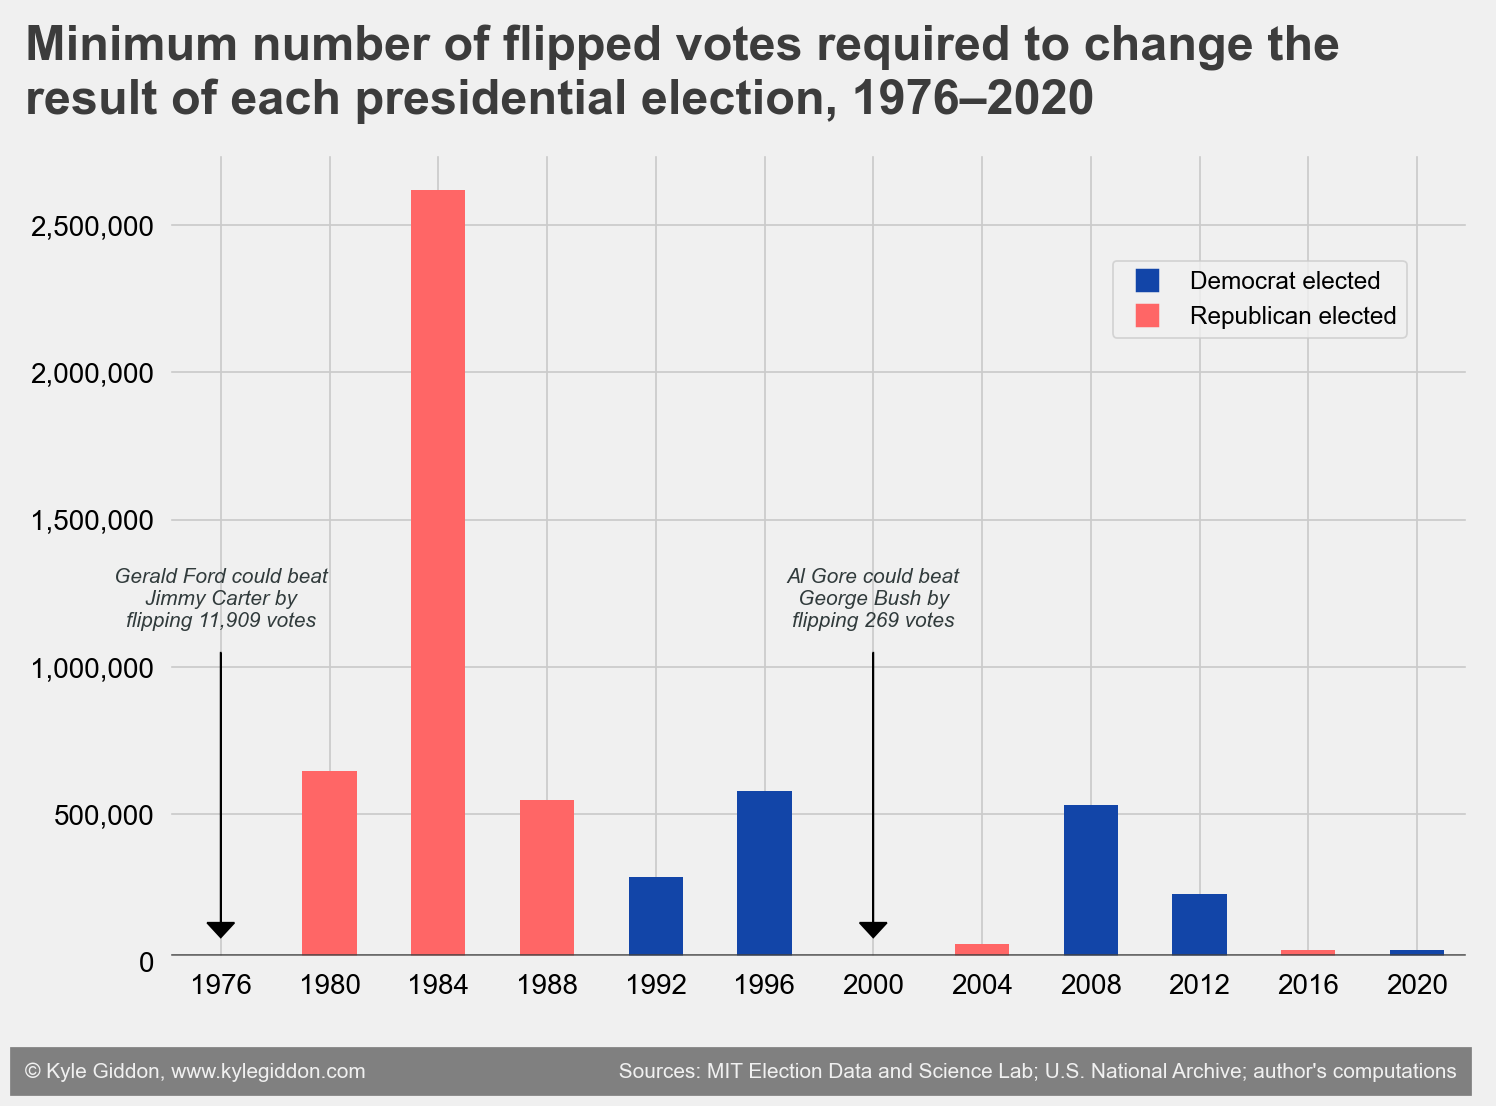

In [2]:
# Master controls
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Plot
y_var = df_total['total_flip_margin']
max_y = max(y_var)
colors = ['#ff6666' if i == 'REPUBLICAN' else '#1245a8' for i in df_total['party_simplified'] ]
y_var.plot.bar(color=colors)

# Formatting
ax.tick_params(axis = 'both', which = 'major', labelsize = 8)
ax.tick_params(axis='x', rotation=0)
ax.axes.grid(linewidth=0.5)
ax.axhline(y=0, color='#414141', linewidth=4, alpha=.8)

ax.text(x = -1.8, y = max_y*1.1, s = "Minimum number of flipped votes required to change the\nresult of each presidential election, 1976–2020",
               fontsize = 14, weight = 'bold', alpha = .75)
# Legend
l1 = mlines.Line2D([], [], color='#ff6666', marker='s', ls='', label='Republican elected')
l2 = mlines.Line2D([], [], color='#1245a8', marker='s', ls='', label='Democrat elected')
ax.legend(handles=[l2, l1],loc=1,bbox_to_anchor=(0.96, 0.88),fontsize=7)

# Axis labels
ax.xaxis.label.set_visible(False)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# Footer
ax.text(x = -1.8, y = max_y*-0.15,s = """© Kyle Giddon, www.kylegiddon.com""" + ''.join(' ' for _ in range(44)) + """Sources: MIT Election Data and Science Lab; U.S. National Archive; author's computations""",fontsize = 6, color = '#f0f0f0', backgroundcolor = 'grey')

# Arrow 1
ax.arrow(0, max_y*0.4, 0, max_y*-0.35, head_width=0.25, head_length=50000, fc='k', ec='k',color='#313B3C')
ax.text(x = 0, y = max_y*0.435,s = """Gerald Ford could beat\nJimmy Carter by\nflipping 11,909 votes""",fontsize = 6, color = '#313B3C',horizontalalignment='center', style='italic')

# Arrow 2
ax.arrow(6, max_y*0.4, 0, max_y*-0.35, head_width=0.25, head_length=50000, fc='k', ec='k',color='#313B3C')
ax.text(x = 6, y = max_y*0.435,s = """Al Gore could beat\nGeorge Bush by\nflipping 269 votes""",fontsize = 6, color = '#313B3C',horizontalalignment='center', style='italic')

fig.savefig('fig1.png', bbox_inches = 'tight')

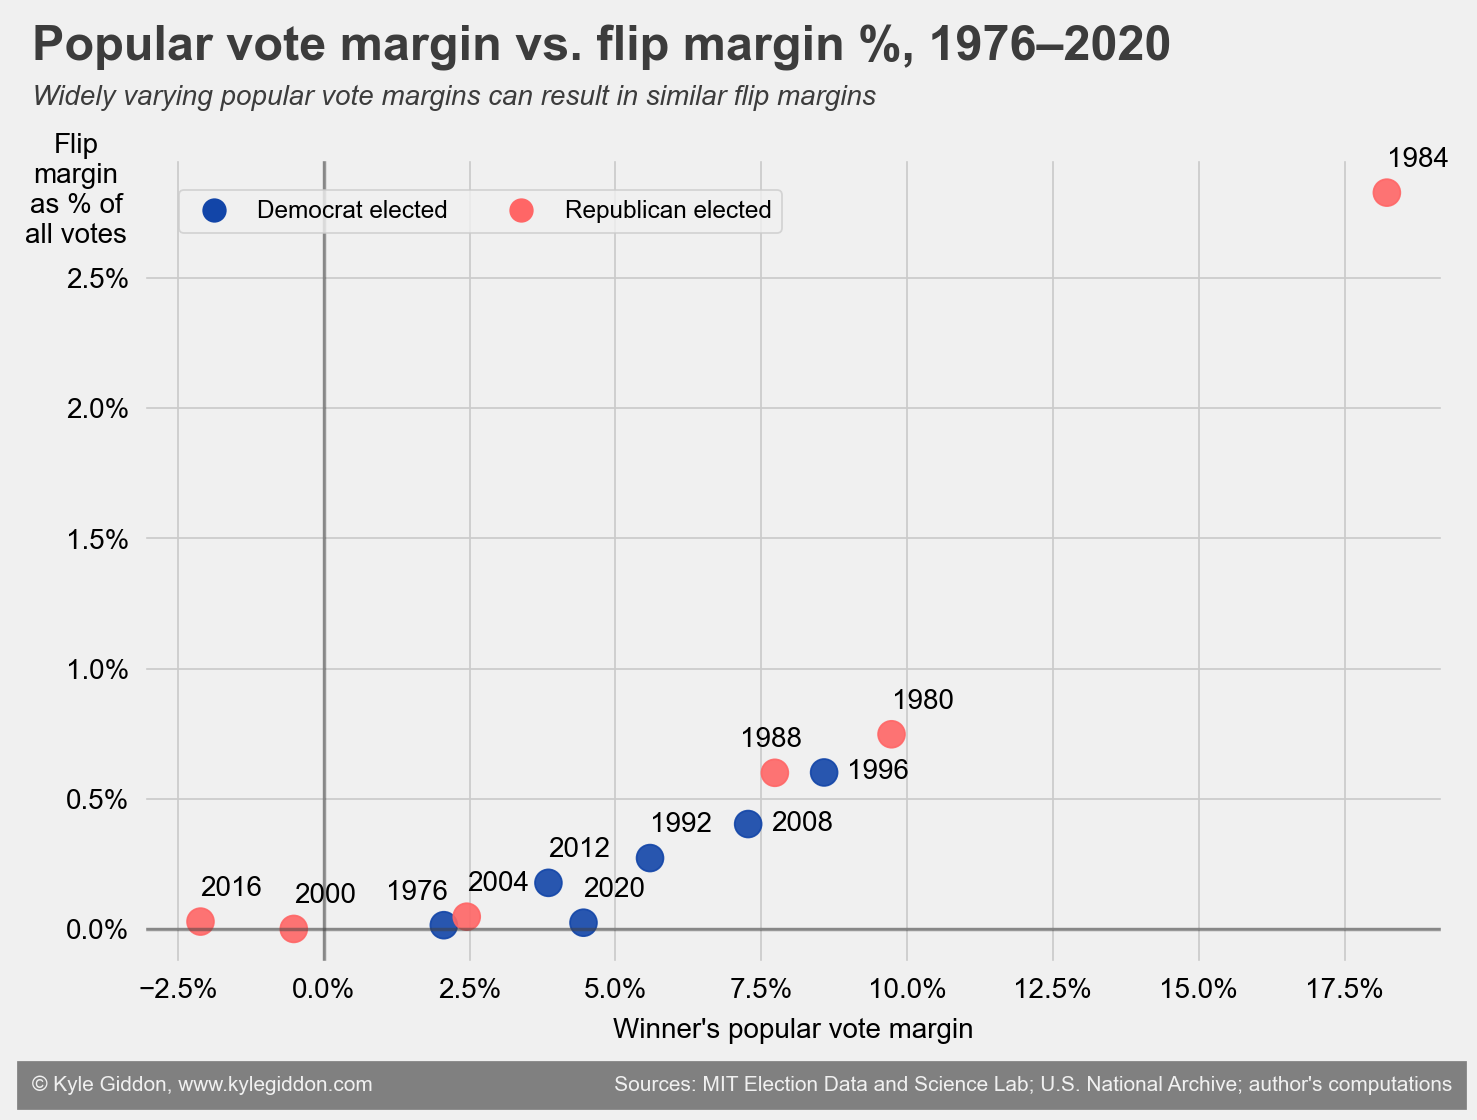

In [3]:
# Master controls
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Formatting
ax.tick_params(axis = 'both', which = 'major', labelsize = 8)
ax.tick_params(axis='x', rotation=0)
ax.axes.grid(linewidth=0.5)
ax.axhline(y=0, color='#414141', linewidth=1, alpha=.5)
ax.axvline(x=0, color='#414141', linewidth=1, alpha=.5)

# Plot
x = df_total['popular_vote_margin']
y = df_total['flip_margin_pct']
plt.scatter(x,y,color=colors,s=60,alpha=0.9)
max_y = max(y)

# Title
ax.text(x = -0.05, y = max_y*1.18, s = "Popular vote margin vs. flip margin %, 1976–2020",
               fontsize = 14, weight = 'bold', alpha = .75)
ax.text(x = -0.05, y = max_y*1.12, s = "Widely varying popular vote margins can result in similar flip margins",
               fontsize = 8, style = 'italic', alpha = .75)


# Legend
l1 = mlines.Line2D([], [], color='#ff6666', marker='o', ls='', label='Republican elected')
l2 = mlines.Line2D([], [], color='#1245a8', marker='o', ls='', label='Democrat elected')
ax.legend(handles=[l2, l1],loc=4,fontsize=7,bbox_to_anchor=(0.5, .89),ncol=2)

# Axis labels
ax.set_ylabel('Flip\nmargin\nas % of\nall votes',rotation=0,size=8)
ax.yaxis.set_label_coords(-0.05,.885)
ax.set_xlabel("""Winner's popular vote margin""",rotation=0,size=8)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=1))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=1))

# Data labels
for i, year in enumerate(df_total.index.values):
    x_annotation = x.iloc[i]
    y_annotation = y.iloc[i]+0.001
    
    # Manually shifting points
    if year == 1976:
        x_annotation -= .01
    if year == 1988:
        x_annotation -= .006   
    if year == 2008:
        x_annotation += .004   
        y_annotation -= .00125    
    if year == 1996:
        x_annotation += .004   
        y_annotation -= .00125              
    
    plt.annotate(year, (x_annotation, y_annotation),size=8)
    
# Footer
ax.text(x = -0.05, y = max_y*-0.22,s = """© Kyle Giddon, www.kylegiddon.com""" + ''.join(' ' for _ in range(42)) + """Sources: MIT Election Data and Science Lab; U.S. National Archive; author's computations""",fontsize = 6, color = '#f0f0f0', backgroundcolor = 'grey')

fig.savefig('fig2.png', bbox_inches = 'tight')

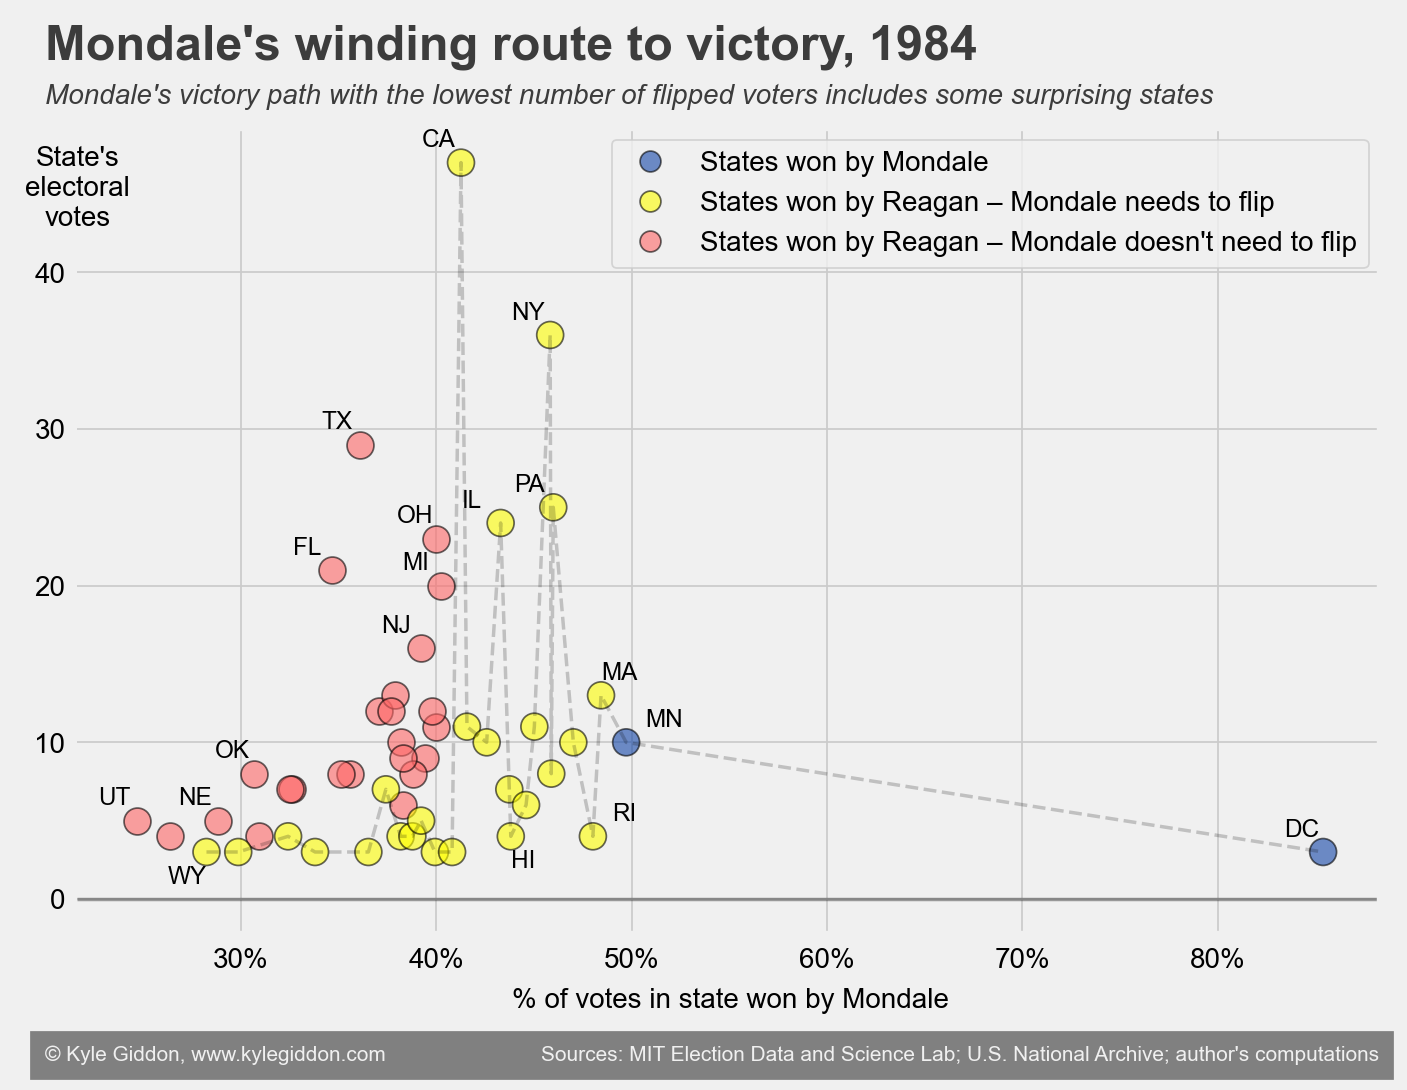

In [4]:
# Master controls
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Formatting
ax.tick_params(axis = 'both', which = 'major', labelsize = 8)
ax.tick_params(axis='x', rotation=0)
ax.axes.grid(linewidth=0.5)
ax.axhline(y=0, color='#414141', linewidth=1, alpha=.5)

# Plot
df_1984_unflipped = df_1984.loc[(df_1984['mondale_flip'] == False) & (df_1984['electoral_votes_candidate_x'] == 0)]
df_1984_flipped = df_1984.loc[(df_1984['mondale_flip'] == True) | (df_1984['electoral_votes_candidate_x'] > 0)].sort_values(by='mondale_pct')

x1 = df_1984_unflipped['mondale_pct']
y1 = df_1984_unflipped['electoral_votes_candidate_y']
plt.scatter(x1,y1,color='#ff6666',s=60,alpha=0.6,edgecolors= "black")

x2 = df_1984_flipped['mondale_pct']
y2 = df_1984_flipped['electoral_votes_candidate_y']
colors = ['#1245a8' if i > 0 else 'yellow' for i in df_1984_flipped['electoral_votes_candidate_x'] ]
plt.plot(x2,y2,color='black',alpha=0.2,linewidth=1,linestyle='--')

plt.scatter(x2,y2,color=colors,s=60,alpha=0.6,edgecolors= "black")
max_y = max(y2)

# Title
ax.text(x = .2, y = max_y*1.14, s = "Mondale's winding route to victory, 1984",
               fontsize = 14, weight = 'bold', alpha = .75)
ax.text(x = .2, y = max_y*1.08, s = """Mondale's victory path with the lowest number of flipped voters includes some surprising states""",
               fontsize = 8, style = 'italic', alpha = .75)

# Legend
l1 = mlines.Line2D([], [], color='#1245a8', marker='o',markeredgecolor='black', markeredgewidth=0.5,alpha=0.6, ls='', label='States won by Mondale')
l2 = mlines.Line2D([], [], color='yellow', marker='o',markeredgecolor='black', markeredgewidth=0.5,alpha=0.6,ls='', label='States won by Reagan – Mondale needs to flip')
l3 = mlines.Line2D([], [], color='#ff6666', marker='o',markeredgecolor='black', markeredgewidth=0.5,alpha=0.6, ls='', label="""States won by Reagan – Mondale doesn't need to flip""")
ax.legend(handles=[l1, l2, l3],loc=1,fontsize=8)

# Axis labels
ax.set_ylabel("""State's\nelectoral\nvotes""",rotation=0,size=8)
ax.yaxis.set_label_coords(0,.87)
ax.set_xlabel("""% of votes in state won by Mondale""",rotation=0,size=8)
ax.spines['left'].set_visible(False)


ax.xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())       

# Data labels
for i, state in enumerate(df_1984['state'].values):
    x_annotation = df_1984.iloc[i,9]
    y_annotation = df_1984.iloc[i,7]
    
    label = lusa.us_state_abbrev(state,uppercase=True)
    
    if label in ['DC','CA','NY','PA','TX','FL','MN','RI','MA','IL','OH','MI','NJ','UT','NE','OK','HI','WY']:
        
        if label == 'WY':
            y_annotation -= 3
        elif label == 'RI':
            x_annotation += .03
        elif label == 'HI':
            x_annotation += .02
            y_annotation -= 3
        elif label == 'MN':
            x_annotation += .03
        elif label == 'MA':
            x_annotation += .02
        
        plt.annotate(label, (x_annotation - .02, y_annotation+1),size=7)
    
# Footer
ax.text(x = 0.2, y = max_y*-0.22,s = """© Kyle Giddon, www.kylegiddon.com""" + ''.join(' ' for _ in range(27)) + """Sources: MIT Election Data and Science Lab; U.S. National Archive; author's computations""",fontsize = 6, color = '#f0f0f0', backgroundcolor = 'grey')
fig.savefig('fig3.png', bbox_inches = 'tight')

In [22]:
# Summary table graphic
clean_flip_states = {k: ', '.join(sorted(str.title(i[0]) for i in v)) for (k,v) in yearly_results.items()}
df_summary_table = pd.DataFrame.from_dict(clean_flip_states,orient='index',columns=['states'])

# Winning and losing candidate names
top_2_candidates = aggregated_votes_no_state.sort_values(by=['year','electoral_votes_candidate'],ascending=False).groupby('year').head(2)
top_2_candidates['candidate'] = top_2_candidates['candidate'].apply(clean_candidate_name)

top_2_candidates_by_year = top_2_candidates.groupby(['year']).agg({'candidate':['first','last']})
top_2_candidates_by_year.columns = top_2_candidates_by_year.columns.to_flat_index()
top_2_candidates_by_year = top_2_candidates_by_year.rename(columns={ top_2_candidates_by_year.columns[0]: "Winning candidate", top_2_candidates_by_year.columns[1]: "Losing candidate" })

# Merge
df_summary_table = pd.merge(df_summary_table,df_total,left_index=True,right_index=True)
df_summary_table = pd.merge(df_summary_table,top_2_candidates_by_year,left_index=True,right_index=True)
df_summary_table.columns = df_summary_table.columns.str.title().str.replace('_',' ')
df_summary_table.loc[df_summary_table['Winning Candidate'] == 'Joseph R. Jr Biden',['Winning Candidate']] = 'Joseph R. Biden Jr.'
df_summary_table.loc[:,['States','Winning Candidate','Losing Candidate','Total Flip Margin','Flip Margin Pct','Popular Vote Margin']].to_csv('summary_table_export.csv')

df_summary_table.head(15)


,States,Total Flip Margin,Candidatevotes,Flip Margin Pct,Party Simplified,Electoral Votes Candidate,Popular Vote Margin,Winning Candidate,Losing Candidate
1976,"Mississippi, Ohio",11909,81601344,0.000146,DEMOCRAT,297.0,0.020594,Jimmy Carter,Gerald Ford
1980,"Alabama, Arkansas, Delaware, Illinois, Kentuck...",646649,86496851,0.007476,REPUBLICAN,448.0,0.097341,Ronald Reagan,Jimmy Carter
1984,"Alaska, California, Delaware, Hawaii, Illinois...",2619374,92654861,0.028270,REPUBLICAN,525.0,0.182256,Ronald Reagan,Walter Mondale
1988,"Alaska, California, Colorado, Connecticut, Del...",549196,91586825,0.005996,REPUBLICAN,426.0,0.077342,George H.W. Bush,Michael Dukakis
1992,"Colorado, Delaware, Georgia, Hawaii, Kentucky,...",284837,104599780,0.002723,DEMOCRAT,370.0,0.055940,Bill Clinton,George H.W. Bush
1996,"Arizona, Delaware, Florida, Kentucky, Missouri...",579287,96389818,0.006010,DEMOCRAT,379.0,0.085785,Bill Clinton,Robert Dole
2000,Florida,269,105593982,0.000003,REPUBLICAN,271.0,-0.005130,George W. Bush,Al Gore
2004,"Colorado, Iowa, New Mexico",57787,122349450,0.000472,REPUBLICAN,286.0,0.024522,George W. Bush,John Kerry
2008,"Colorado, Florida, Indiana, New Hampshire, Nor...",529529,131419253,0.004029,DEMOCRAT,364.0,0.072764,Barack H. Obama,John Mccain
2012,"Florida, Nevada, Ohio, Virginia",228817,129139997,0.001772,DEMOCRAT,332.0,0.038526,Barack H. Obama,Mitt Romney
